In [ ]:
import pandas as pd

#loading our VIX file and viewing the columns to get an idea of what our data looks like
data_path = 'VIX.csv'
vix_data = pd.read_csv(data_path)

print(vix_data.head())


         DATE    VIX
0  31/03/2014  13.88
1  01/04/2014  13.10
2  02/04/2014  13.09
3  03/04/2014  13.37
4  04/04/2014  13.96


# preporocessing:

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

vix_values = vix_data['VIX'].values.reshape(-1, 1)


#normalizing the data :
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_vix = scaler.fit_transform(vix_values)

import torch
tensor_vix = torch.Tensor(normalized_vix)


In [ ]:

generator = Generator()
discriminator = Discriminator()

#using binary cross entropy loss here
criterion = nn.BCELoss()


optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002,betas=(0.5, 0.999))

# Number of epochs and batch size
epochs = 200
batch_size = 32


In [ ]:
import pandas as pd

data_path = 'VIX.csv'
vix_data = pd.read_csv(data_path)

import numpy as np
from sklearn.preprocessing import MinMaxScaler

vix_values = vix_data['VIX'].values.reshape(-1, 1)


#normalize :
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_vix = scaler.fit_transform(vix_values)

import torch
tensor_vix = torch.Tensor(normalized_vix)
import torch.nn as nn

#This is a vanilla GAN model so we're defining basic linear layers with tanh output activation in the geenrator.
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

#This is a vanilla GAN model so we're defining basic linear layers with sigmoid output activation in the discriminator.

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()
discriminator = Discriminator()

#using binary cross entropy loss here
criterion = nn.BCELoss()


optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002,betas=(0.5, 0.999))

# Number of epochs and batch size
epochs = 200
batch_size = 32
import numpy as np

# To store losses and discriminator accuracy
losses = []
accuracies = []
real_stats = []
fake_stats = []

def get_stats(tensor):
    with torch.no_grad():
        np_tensor = tensor.cpu().numpy()
        mean = np.mean(np_tensor)
        std = np.std(np_tensor)
        return mean, std

for epoch in range(epochs):
    epoch_real_loss = 0
    epoch_fake_loss = 0
    epoch_generator_loss = 0
    correct_real = 0
    correct_fake = 0
    total_samples = 0

    for i in range(0, len(tensor_vix), batch_size):

        current_batch_size = min(batch_size, len(tensor_vix) - i)
        total_samples += current_batch_size


        real_vix = tensor_vix[i:i+current_batch_size]

        #generating the fake samples

        noise = torch.randn(current_batch_size, 100)
        fake_vix = generator(noise)

        #train:
        optimizer_D.zero_grad()
        real_decision = discriminator(real_vix)
        real_loss = criterion(real_decision, torch.ones_like(real_vix))
        real_loss.backward()
        epoch_real_loss += real_loss.item()

        fake_decision = discriminator(fake_vix.detach())
        fake_loss = criterion(fake_decision, torch.zeros_like(fake_vix))
        fake_loss.backward()
        epoch_fake_loss += fake_loss.item()

        optimizer_D.step()

        #discriminmator accuracy
        correct_real += torch.sum(real_decision > 0.5)
        correct_fake += torch.sum(fake_decision <= 0.5)

        optimizer_G.zero_grad()
        generator_loss = criterion(discriminator(fake_vix), torch.ones_like(fake_vix))
        generator_loss.backward()
        optimizer_G.step()
        epoch_generator_loss += generator_loss.item()

    #LOSSES
    losses.append((epoch_real_loss + epoch_fake_loss) / 2)
    accuracies.append((correct_real + correct_fake).float() / total_samples / 2)

    #STORING FAKE and real data
    real_stats.append(get_stats(real_vix))
    fake_stats.append(get_stats(fake_vix))

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, D_loss: {losses[-1]:.4f}, G_loss: {epoch_generator_loss/current_batch_size:.4f}, D_acc: {accuracies[-1]*100:.2f}%')
        #we're comparing the mean cuz we can't compare accuracy here !


        real_mean, real_std = real_stats[-1]
        fake_mean, fake_std = fake_stats[-1]
        print(f'Statistics - Real: mean={real_mean:.4f}, std={real_std:.4f}; Fake: mean={fake_mean:.4f}, std={fake_std:.4f}')

Epoch 10/200, D_loss: 29.9693, G_loss: 2.6994, D_acc: 46.27%
Statistics - Real: mean=-0.6702, std=0.0731; Fake: mean=-0.6743, std=0.1352
Epoch 20/200, D_loss: 28.0168, G_loss: 2.5998, D_acc: 50.95%
Statistics - Real: mean=-0.6702, std=0.0731; Fake: mean=-0.9128, std=0.0489
Epoch 30/200, D_loss: 27.6728, G_loss: 2.5557, D_acc: 51.11%
Statistics - Real: mean=-0.6702, std=0.0731; Fake: mean=-0.7222, std=0.1756
Epoch 40/200, D_loss: 27.7513, G_loss: 2.5427, D_acc: 49.01%
Statistics - Real: mean=-0.6702, std=0.0731; Fake: mean=-0.4484, std=0.3808
Epoch 50/200, D_loss: 27.7466, G_loss: 2.5225, D_acc: 48.89%
Statistics - Real: mean=-0.6702, std=0.0731; Fake: mean=-0.6289, std=0.2774
Epoch 60/200, D_loss: 28.5707, G_loss: 2.5055, D_acc: 43.49%
Statistics - Real: mean=-0.6702, std=0.0731; Fake: mean=-0.8688, std=0.0750
Epoch 70/200, D_loss: 28.0859, G_loss: 2.6706, D_acc: 54.85%
Statistics - Real: mean=-0.6702, std=0.0731; Fake: mean=-0.8736, std=0.0954
Epoch 80/200, D_loss: 27.8579, G_loss: 2.

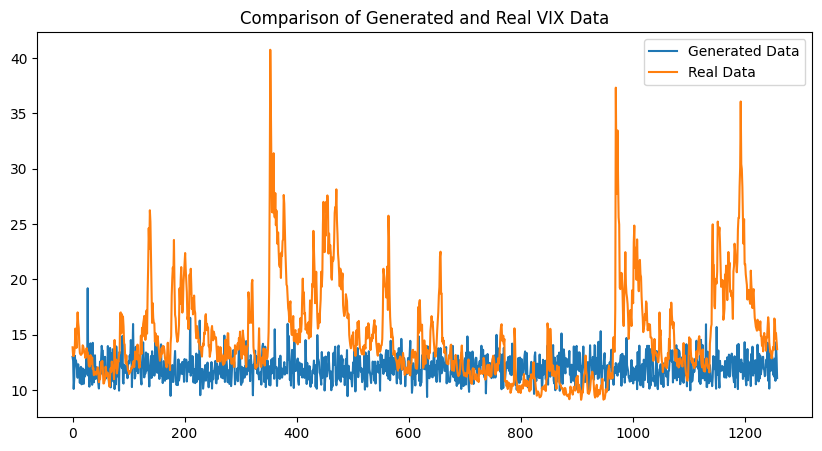

In [ ]:
import matplotlib.pyplot as plt

# Generate new samples
noise = torch.randn(len(vix_data), 100)  # Generate the same number of samples as real data
generated_samples = generator(noise).detach().numpy()

# Transform back to original scale
generated_samples = scaler.inverse_transform(generated_samples)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(generated_samples, label='Generated Data')
plt.plot(vix_data['VIX'].values, label='Real Data')
plt.title('Comparison of Generated and Real VIX Data')
plt.legend()
plt.show()
